# HW3 !

## Preparations

### Installs

In [26]:
!pip install torchvision

In [27]:
!pip install opencv-python

In [28]:
!pip install scikit-learn

In [29]:
!pip install scikit-image

### Imports

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from PIL.JpegImagePlugin import JpegImageFile

import cv2

In [31]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt

In [32]:
from typing import Optional, Union, Tuple, List
import json

import random

# TODO: sort imports !

### Reproducability settings

In [33]:
seed=42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

### Definitions

In [ ]:
pass

### Common functions

In [34]:
def get_top_k_predictions(results_tensor: torch.Tensor, k: int=3, mapping: Optional[dict] = None, use_print:bool = False) -> List[int]:
    #
    topk_results = torch.topk(results_tensor, k=k, largest=True, sorted=True,)
    
    # assumption: using the imagenet's 1000 classes
    if mapping is not None:
        class_names = [mapping[index] for index in topk_results.indices.tolist()]
        
    if use_print:
        print(f"\nPrints from get_top_k_predictions")
        print(f"topk values: {topk_results.values.tolist()}")
        print(f"topk indices: {topk_results.indices.tolist()}")
        print(f"class_names: {class_names}")

    return topk_results.indices.tolist()

In [68]:
def get_top_k_indices(
        vector: Union[torch.Tensor, np.ndarray], 
        k: int = 3, 
        largest: bool = True,
        use_print:bool = False) -> List[int]:
    
    if isinstance(vector, np.ndarray):
        vector_tensor = torch.from_numpy(vector)
    else:
        vector_tensor = vector

    topk_results = torch.topk(vector_tensor, k=k, largest=largest, sorted=True)
        
    if use_print:
        print(f"\nPrints from get_top_k_predictions")
        print(f"topk values: {topk_results.values.tolist()}")
        print(f"topk indices: {topk_results.indices.tolist()}")

    return topk_results.indices.tolist()

In [35]:
def plot_image_with_segments(input_image: Union[np.ndarray, torch.Tensor, JpegImageFile], segments: np.ndarray, title: str = "") -> None:
    if input_image.shape[0] == 3:
        # change (CxHxW) to (HxWxC)
        input_image = input_image.permute(1,2,0)
    
    plt.figure(0)
    plt.title(title)
    plt.imshow(mark_boundaries(input_image, segments))
    plt.axis("off")
    # show the plots
    plt.show()

In [36]:
def calculate_similarity():
    raise

### Common classes

In [37]:
class SuperpixelImage:
    def __init__(self, input_image: Image, number_of_segments_in_image: int = 50, sigma: int = 5) -> None:
        # Treat image
        self.original_input_image: Image = input_image
        self.image: np.ndarray = np.array(input_image) # squeeze to remove batch dimension, permute to move channel dimension to end (for plotting), detach to remove gradient tracking, convert to numpy
        self.number_of_segments_in_image_expected: int = number_of_segments_in_image
        self.sigma = sigma
        self._calculate_segments()

        # Setup for later
        self.transform_pil_to_torch_for_model = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256,256), antialias=True),
            # transforms.CenterCrop((224,224)),
            # for explanation on normalizatio values - see https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

    def _calculate_segments(self) -> None:
        # Note: SLIC algo. expects the input image to be of shape (HxWxC) if it is not greyscale
        self.segments: np.ndarray = slic(
            self.image, n_segments=self.number_of_segments_in_image_expected, sigma=self.sigma)

        self.number_of_segments_in_image_actual: int = self.segments.max()

    def prepare_for_model(self, image: Optional[Union[JpegImageFile, np.ndarray, torch.Tensor]] = None, use_print: bool = False) -> torch.Tensor:
        if image is None or isinstance(image, JpegImageFile):
            image_tensor_transformed = self.transform_pil_to_torch_for_model(self.original_input_image)
        elif isinstance(image, np.ndarray):
            image_tensor_transformed = self.transform_pil_to_torch_for_model(image)
        else:
            # else this is a torch tensor and needs no work
            image_tensor_transformed = image
        
        if len(image_tensor_transformed) != 4:
            # AKA missing batch dimension
            image_tensor_transformed_with_batch = image_tensor_transformed.unsqueeze(0)
        else:
            image_tensor_transformed_with_batch = image_tensor_transformed
            

        if use_print is True:
            print(f"Entered prepare_for_model")
            print(f"image_tensor_transformed.shape {image_tensor_transformed.shape}")
            print(f"image_tensor_transformed_with_batch.shape {image_tensor_transformed_with_batch.shape}")

        return image_tensor_transformed_with_batch

    def generate_random_pertrubation(self, use_print: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        # generate  random interpretation vector with values between (0, 1)
        # aka binaric_superpixel_vector
        random_interpretation_vector = np.random.randint(2, size=self.number_of_segments_in_image_actual)

        # get indices and 
        superpixels_to_include_indices = np.where(random_interpretation_vector == 1)[0]

        image_masked = self.generate_pertrubation_from_indices(
            superpixels_to_include_indices=superpixels_to_include_indices, 
            use_print=use_print)

        # # make a mask, where all the non wanted superpixels will be masked (values == 0)
        # mask = np.where(np.isin(self.segments, test_elements=superpixels_to_include_indices), 1, 0)

        # # duplicate the 2d mask to 3d (so it can be applied to iamge)
        # mask_3d = np.dstack([mask] * 3)

        # # apply mask to image
        # image_masked = np.where(mask_3d == 1, self.image, 0) # can also be achieved by multiplication

        # #
        if use_print is True:
            print(f"Entered generate_random_pertrubation")
            print(f"random_interpretation_vector.shape {random_interpretation_vector.shape}")
            print(f"superpixels_to_include_indices.shape {superpixels_to_include_indices.shape}")
            # print(f"mask.shape {mask.shape}")
            # print(f"mask_3d.shape {mask_3d.shape}")


        return image_masked, random_interpretation_vector
    
    def generate_pertrubation_from_indices(self, superpixels_to_include_indices: List[int], use_print: bool = False) -> np.ndarray:
        # make a mask, where all the non wanted superpixels will be masked (values == 0)
        mask = np.where(np.isin(self.segments, test_elements=superpixels_to_include_indices), 1, 0)

        # duplicate the 2d mask to 3d (so it can be applied to iamge)
        mask_3d = np.dstack([mask] * 3)

        # apply mask to image
        image_masked = np.where(mask_3d == 1, self.image, 0) # can also be achieved by multiplication

        #
        if use_print is True:
            print(f"Entered generate_pertrubation_from_indices")
            # print(f"random_interpretation_vector.shape {random_interpretation_vector.shape}")
            # print(f"superpixels_to_include_indices.shape {superpixels_to_include_indices.shape}")
            print(f"mask.shape {mask.shape}")
            print(f"mask_3d.shape {mask_3d.shape}")


        return image_masked




In [38]:
class LocalDataset(Dataset):
    def __init__(self, model, class_index: int, super_pixel_image: SuperpixelImage, num_images_to_generate: int = 5):
        self.model = model
        self.class_index = class_index
        self.super_pixel_image = super_pixel_image
        self.num_images_to_generate = num_images_to_generate

    def __len__(self):
        return self.num_images_to_generate

    def __getitem__(self, idx):
        # generate new image
        new_image, vector_representation = self.super_pixel_image.generate_random_pertrubation()

        # generate label
        prepared_image_For_model = self.super_pixel_image.prepare_for_model(new_image)
        predictions = self.model(prepared_image_For_model).squeeze()
        pertrubation_label: int = get_top_k_predictions(predictions, k=1)[0] 
        new_image_label = 1 if pertrubation_label == self.class_index else 0

        # generate similarity measeurment
        sigma_squared = 1e+6
        distance_squared = np.sum((self.super_pixel_image.image - new_image)**2, axis=0)
        similarity = np.exp(distance_squared / sigma_squared)

        # return
        return new_image, new_image_label, vector_representation, similarity


### Optional: Label mapping

In [39]:

# Note: mapping between imagenet images and their labels was taken from https://www.kaggle.com/datasets/juliangarratt/imagenet-class-index-json?resource=download

path_to_mapping = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/imagenet_labels.json'

with open(path_to_mapping, 'rb') as fp:
    raw_label_mapping = json.load(fp)

    label_mapping = {
        int(key): value[1]
        for key, value in raw_label_mapping.items()
    }

len(label_mapping)

1000

In [40]:
label_mapping[0]

'tench'

## Part 0 

### Choosing the model

In [41]:
# On first run of this cell, model weights will be loaded
model = resnet50(weights="IMAGENET1K_V2")

### Choosing the images

images taken from https://github.com/EliSchwartz/imagenet-sample-images

In [42]:
path_to_data_dir = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data'

In [43]:
image_banana_path = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/n07753592_banana.JPEG'
image_pizza_path = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/n07873807_pizza.JPEG'
image_tennisball_path = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/n04409515_tennis_ball.JPEG'

In [44]:
image_banana = Image.open(image_banana_path)
image_pizza = Image.open(image_pizza_path)
image_tennisball = Image.open(image_tennisball_path)

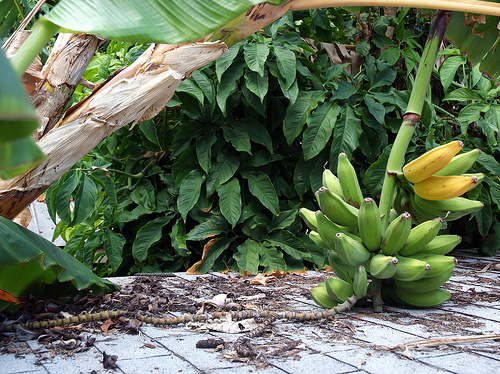

In [45]:
# display is a jupyter method
display(image_banana)

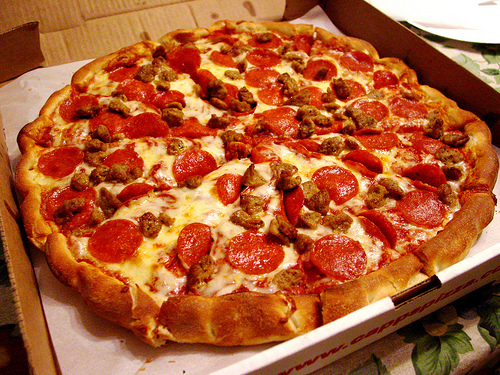

In [46]:
# display is a jupyter method
display(image_pizza)

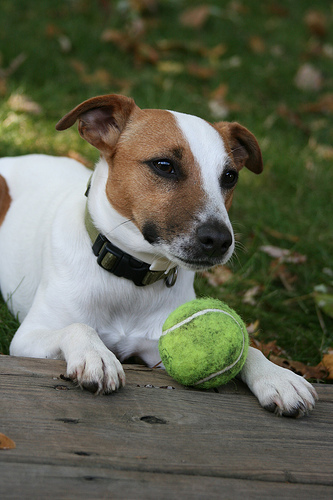

In [47]:
# display is a jupyter method
display(image_tennisball)

## Part 1

> For each image, 𝑥, perform the following: 

3) Get the top 3 classes from the model

4) Interpretable (simplified) instances: 

    a) Generate interpretable versions of the images you chose by either splitting them to super-pixels. You can use the CV2 package for that.  
    b) Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels 𝑥$∈{0,1}%!
  
5) For each class perform 𝑓&: 

    a) Local dataset generation 

        i) Generate  a  set  of  random  perturbations  of  the  interpretable  instances  by  uniformly choosing which parts to include 𝑧$∈{0,1}%!
        
        ii) For each generated interpretable instance, generate the corresponding image 𝑧 and get its label 𝑓&(𝑧) 

        iii) Calculate the similarity of the perturbed instance from the original image 𝜋'(𝑧) 

    b) Fit a local surrogate model 𝑔 and generate explanations 

        i) Fit a linear model with locally weighted loss (using 𝜋') and 𝐿! regularization on the generated dataset. Use K-Lasso for feature selection. 
        
        ii) Find and present the set of important features (super-pixels/tiles) for the prediction 𝑓(𝑥)

### Part 1 
### First image: tennisball

#### Part 1 Section 3: Get the top 3 classes from the model

In [48]:
tennisball_image_class: SuperpixelImage = SuperpixelImage(image_tennisball)
image_tensor_tennisball_transformed = tennisball_image_class.prepare_for_model()
result_tennisball = model(image_tensor_tennisball_transformed).squeeze()
class_indices = get_top_k_predictions(result_tennisball, mapping=label_mapping, use_print=True)


Prints from get_top_k_predictions
topk values: [1.544899821281433, 1.1374542713165283, 1.0009381771087646]
topk indices: [852, 180, 242]
class_names: ['tennis_ball', 'American_Staffordshire_terrier', 'boxer']


#### Part 1 Section 4: Interpretable (simplified) instances

    a) Generate interpretable versions of the images you chose by either splitting them to super-pixels. You can use the CV2 package for that.  
    
    b) Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels
 

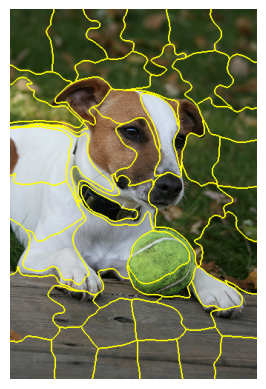

The binary vector representation of the original image, is a vector with all values ==1 (all superpixels activated)


In [49]:
# Plotting the original image with segmentation
plot_image_with_segments(
    input_image=tennisball_image_class.image, 
    segments=tennisball_image_class.segments)

print(f"The binary vector representation of the original image, is a vector with all values ==1 (all superpixels activated)")

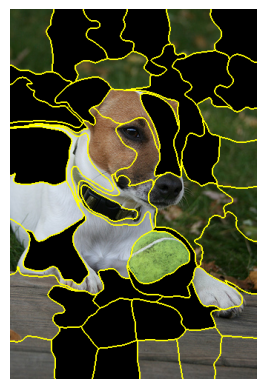

Binary vector of the image (superpixels activation): [0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1
 0 0 0 0 0 1 1 1 1]


In [50]:
# Plotting a pertrubation image with segmentation
pertrubation_image, binary_vector = tennisball_image_class.generate_random_pertrubation()

plot_image_with_segments(
    input_image=pertrubation_image, 
    segments=tennisball_image_class.segments)

print(f"Binary vector of the image (superpixels activation): {binary_vector}")

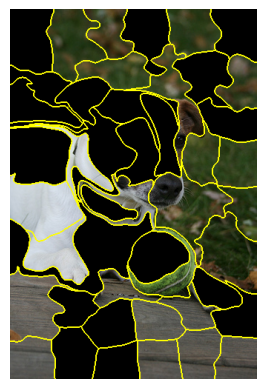

Binary vector of the image (superpixels activation): [1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0
 1 0 0 1 0 1 1 1 1]


In [51]:
# Plotting a pertrubation image with segmentation
pertrubation_image, binary_vector = tennisball_image_class.generate_random_pertrubation()

plot_image_with_segments(
    input_image=pertrubation_image, 
    segments=tennisball_image_class.segments)

print(f"Binary vector of the image (superpixels activation): {binary_vector}")

#### Part 1 Section 5: For each class perform: 

    a) Local dataset generation

    b) Fit a local surrogate model 𝑔 and generate explanations

In [52]:
new_dataset = LocalDataset(
    model=model,
    class_index=class_indices[0],
    super_pixel_image=tennisball_image_class,
    num_images_to_generate=100
)

In [53]:
# new_dataset[0]

In [54]:
# create a dataloader that returns a single batch of the entire dataset
dataloader = DataLoader(dataset=new_dataset, batch_size=len(new_dataset))
images, labels, binary_vectors, similarities = next(iter(dataloader))

In [55]:
print(f"images.shape {images.shape}")
print(f"labels.shape {labels.shape}")
print(f"binary_vectors.shape {binary_vectors.shape}")
print(f"similarities.shape {similarities.shape}")

images.shape torch.Size([100, 500, 333, 3])
labels.shape torch.Size([100])
binary_vectors.shape torch.Size([100, 46])
similarities.shape torch.Size([100, 333, 3])


In [56]:
similarities

tensor([[[1.0130, 1.0119, 1.0145],
         [1.0111, 1.0142, 1.0145],
         [1.0144, 1.0131, 1.0150],
         ...,
         [1.0325, 1.0300, 1.0304],
         [1.0330, 1.0296, 1.0300],
         [1.0308, 1.0308, 1.0300]],

        [[1.0322, 1.0308, 1.0316],
         [1.0294, 1.0273, 1.0352],
         [1.0297, 1.0297, 1.0339],
         ...,
         [1.0389, 1.0344, 1.0361],
         [1.0393, 1.0340, 1.0361],
         [1.0368, 1.0349, 1.0358]],

        [[1.0346, 1.0342, 1.0343],
         [1.0326, 1.0325, 1.0366],
         [1.0330, 1.0342, 1.0357],
         ...,
         [1.0555, 1.0501, 1.0512],
         [1.0553, 1.0526, 1.0482],
         [1.0513, 1.0508, 1.0499]],

        ...,

        [[1.0301, 1.0330, 1.0334],
         [1.0281, 1.0309, 1.0329],
         [1.0301, 1.0325, 1.0341],
         ...,
         [1.0177, 1.0134, 1.0156],
         [1.0167, 1.0138, 1.0155],
         [1.0161, 1.0134, 1.0158]],

        [[1.0541, 1.0524, 1.0548],
         [1.0504, 1.0528, 1.0584],
         [1.

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
g_model = LogisticRegression(penalty="l1", solver="liblinear")

g_model.fit(X=binary_vectors, y=labels)

LogisticRegression(penalty='l1', solver='liblinear')

In [59]:
# squeeze is to get rid of the useless "1" dimension that makes this a column vector instead of a row vector
feature_importances: np.ndarray = g_model.coef_.squeeze()  # TODO: consider using ABS here
feature_importances

array([ 0.        ,  0.04143078, -0.60168812, -0.52664748,  0.        ,
        0.        , -0.19008328,  0.24208444,  0.        ,  0.        ,
       -0.42260315,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.12715371,  0.15753245,  0.        ,  0.        ,  0.        ,
        0.05195681,  0.        ,  0.11376731, -0.23401947,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  3.86000887,  0.        ,  0.        ,
       -0.11689414, -0.14471256, -0.30280651,  0.25955311, -0.26297777,
        0.        , -0.22273474,  0.        ,  0.        ,  0.01624275,
        0.        ])

In [69]:
positive_important_feature_indices: List[int] = get_top_k_indices(feature_importances, largest=True)
negative_important_feature_indices: List[int] = get_top_k_indices(feature_importances, largest=False)

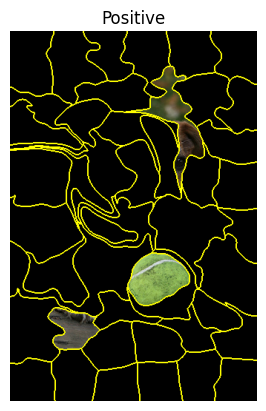

In [70]:

pertrubation_image = tennisball_image_class.generate_pertrubation_from_indices(
    positive_important_feature_indices)

plot_image_with_segments(
    input_image=pertrubation_image, 
    segments=tennisball_image_class.segments,
    title="Positive")

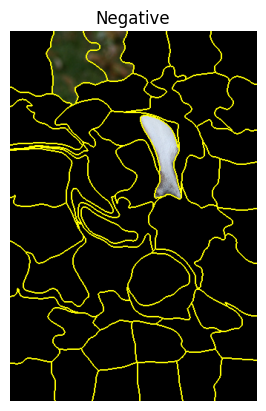

In [71]:

pertrubation_image = tennisball_image_class.generate_pertrubation_from_indices(
    negative_important_feature_indices)

plot_image_with_segments(
    input_image=pertrubation_image, 
    segments=tennisball_image_class.segments,
    title="Negative")

In [ ]:

# read list:
## https://stackoverflow.com/questions/68530131/threshold-in-a-superpixel-opencv2
## https://pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/

Questions:

Fit a linear model with locally weighted loss (using pi_x) and L1 regularization on the 
generated dataset. Use K-Lasso for feature selection

> How to add locally weighted loss ??

> what is k-lasso ?

> how is the label defined exactly ?

> sho0uld the model be trained only with samples that have label "1" ?

# TODO

make it work without anything saved on the computer 

> images from internet

> without mapping

> else